In [37]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns

from collections import Counter
from matplotlib import pyplot as plt
from preprocess import preprocessor
from preprocess import clean_df
from preprocess import define_vocab_to_remove
from sklearn.preprocessing import LabelEncoder


## **Introduction**
For this project I used a dataset of news article titles from kaggle <br>
The objective is too create a classifying model that is able to predict with precision the category of the news article based on it's title


In [38]:
data = pd.read_csv("labelled_newscatcher_dataset.csv", sep=";") # We import the data

X, y = clean_df(data) # Initial clean of the dataset
X.head(3)

0    A closer look at water-splitting's solar fuel ...
1    An irresistible scent makes locusts swarm, stu...
2    Artificial intelligence warning: AI will know ...
Name: title, dtype: object

In [39]:
y.head(3)

0    SCIENCE
1    SCIENCE
2    SCIENCE
Name: topic, dtype: object

I kept only the column that were necessary for the study. Here the training data will be the titles, and the target is the topic

## Explanatory data analysis

First I want to verify the topics distribution in my dataset. This will allow me to take appropriate measures for the training of the model based on the how the dataset if balanced.

topic
TECHNOLOGY       15000
HEALTH           15000
WORLD            15000
ENTERTAINMENT    15000
SPORTS           15000
BUSINESS         15000
NATION           15000
SCIENCE           3774
Name: count, dtype: int64


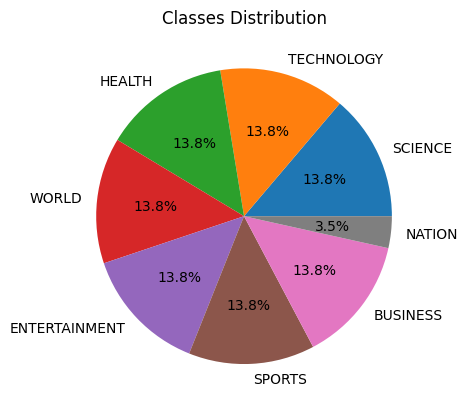

In [16]:
topic_count = y.value_counts()
print(topic_count)

plt.pie(topic_count, labels = y.unique().tolist(), autopct='%1.1f%%') # Display the distribution as a pie chart
plt.title("Classes Distribution")
plt.show()

I now want to see the length of the titles based on the topic. To do this I first create a new column with the word_count for each title

In [44]:
df = pd.DataFrame({"title":X,"topic":y}) # Join back my cleaned up data
df['word_count'] = df["title"].apply(lambda x: len(x.split()))
df.head(3)

,title,topic,word_count
0,A closer look at water-splitting's solar fuel ...,SCIENCE,8
1,"An irresistible scent makes locusts swarm, stu...",SCIENCE,8
2,Artificial intelligence warning: AI will know ...,SCIENCE,12


I then compute the average word_count for each categories

In [45]:
grouped = df.groupby('topic')
average_df = grouped['word_count'].mean()
average_df

topic
BUSINESS         12.168600
ENTERTAINMENT    12.321533
HEALTH           10.898333
NATION           10.837933
SCIENCE          10.915474
SPORTS           11.514067
TECHNOLOGY       11.375333
WORLD            10.875533
Name: word_count, dtype: float64

I now want to display the overall title length distribution in a graph. For this i define the following function

In [51]:
def plot_histo(df):
    plt.hist(df["word_count"],bins=30, rwidth=0.8)
    plt.title("Title length distribution")
    plt.xlabel("title length")
    plt.ylabel("nb samples")
    plt.show()

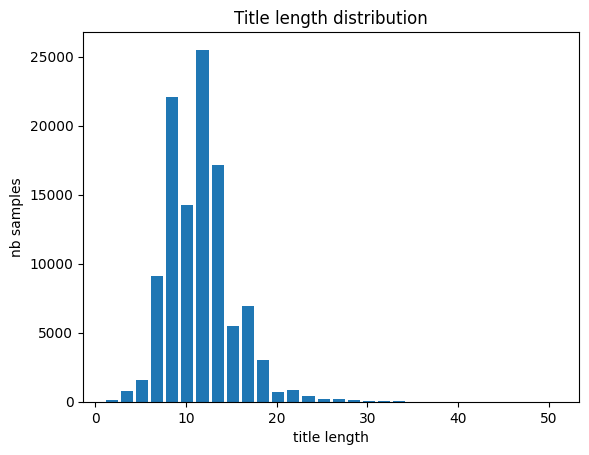

In [52]:
plot_histo(df)

We can see from this graph that some titles are quite short (<5 words) and some are long (>25). This information is to keep in mind when we will preprocess the data

I now want to see the most represented words in my dataset. <br>
To do this i need to first define a vocabulary and then use the most_common function to find the 20 most common words

c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


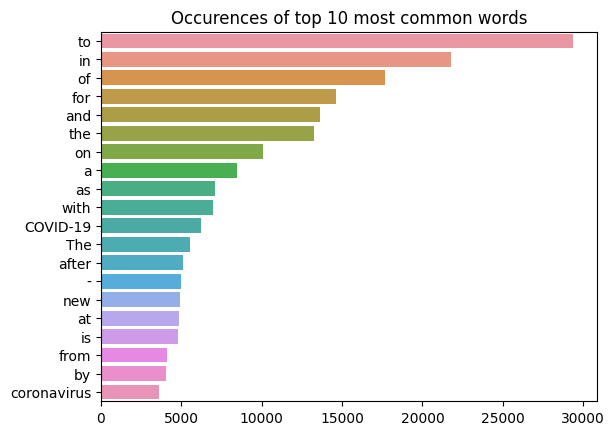

In [69]:
full_text = ' '.join(X)
split_text = full_text.split()

count = Counter(split_text)
most_common = count.most_common()

def plot_most_common(most_comm,nb):
        words = []
        count = []
        for word, cnt in most_common[:nb]:
                words.append(word)
                count.append(cnt)

        sns.barplot(x = count, y= words)
        plt.title("Occurences of top 10 most common words")
        plt.show()

plot_most_common(most_common,20)

We can see that the most represented words are stopwords and some punctuations. Let's remove them to have a better representation

In [70]:
# defining the most common words
from nltk.corpus import stopwords
import string
stop_words = set(stopwords.words('english'))
translation_table = str.maketrans(dict.fromkeys(string.punctuation))

# new list without stopwords and punctuation. We also apply lowercase to include more words
split_text_wo_sw = [word.lower() for word in split_text if (word.lower() not in stop_words) and word.isalnum()] 

vocab = Counter(split_text_wo_sw) # update the vocabulary
most_common = vocab.most_common() 

c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


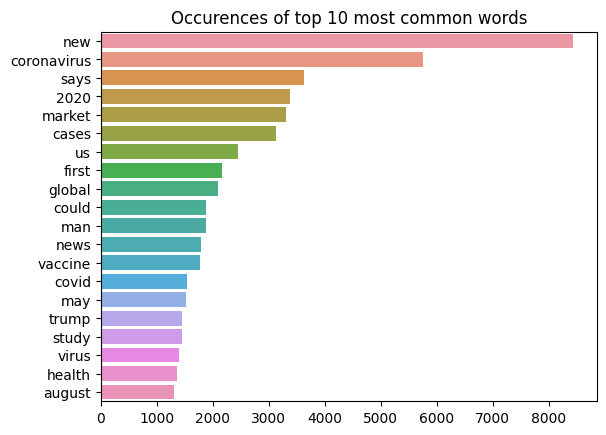

In [72]:
plot_most_common(most_common,20)

Let's see how many words appears more than a 1000 time

In [77]:
frequent_words = []
for word, cnt in most_common:
    if cnt > 1000:
        frequent_words.append(word)
    
print(f"Number of words that appears more than 1000 times: {len(frequent_words)}")

Number of words that appears more than 1000 times: 47


Les't do the same but to see how many words appears only 1 time 

In [79]:
rare_words = []
for word, cnt in most_common:
    if cnt == 1:
        rare_words.append(word)

print(f"Number of words that appears more than 1000 times: {len(rare_words)}")

Number of words that appears more than 1000 times: 19160


In [80]:
print(f"Number of frequent and rare words : {len(rare_words)+ len(frequent_words)}")

Number of frequent and rare words : 19207


This is the amount of unique words that we would need to remove when preprocessing the data. For this exampe we used 1 < appearance < 1000 as thresholds. We might want to adjust these values to optimize our model's efficienty in the future